# Program Jepa trainer

> This module implements Program Jepa training procedure.

In [ ]:
#| default_exp trainers.trainer_progjepa

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore import *
from fastcore.utils import *
from torchvision.utils import save_image
import torch
import os
from torch import nn
import pandas as pd

In [ ]:
# #| hide
# import torch
# from torchvision.transforms import v2
# train_tf = v2.Compose(
#     [
#         # Keep the size at 42 to match your model architecture
#         v2.ToPILImage(),
#         # v2.RandomResizedCrop(42, scale=(0.8, 1.0)), 
#         # v2.RandomApply([v2.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
#         # v2.RandomGrayscale(p=0.2),
#         # Reduced kernel size for smaller image resolution
#         # v2.RandomApply([v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.1),
#         # v2.RandomHorizontalFlip(),
#         v2.ToImage(),
#         v2.ToDtype(torch.float32, scale=True),
#         # Normalizes to [-1, 1] to match Tanh output
#         v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     ]
# )

In [ ]:
# #| hide
# from MAWM.data.loaders import RolloutObservationDataset

# from torchvision import transforms
# import numpy as np

# ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE =\
#     3, 32, 256, 32, 40

# dataset = RolloutObservationDataset(
#     agent='agent_0',
#     root='../marl_grid_data/',
#     transform=train_tf,
#     buffer_size=10,
#     train=True
# )
# dataset.load_next_buffer()

Loading file buffer ...: 100%|██████████| 10/10 


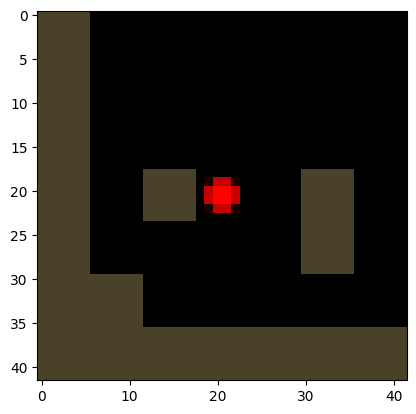

In [ ]:
# #| hide
# import matplotlib.pyplot as plt
# def denormalize(tensor):
#     # If using mean=0.5, std=0.5:
#     return tensor * 0.5 + 0.5
    
#     # If using ImageNet stats (your current code):
#     # mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
#     # std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
#     # return tensor * std + mean

# # Visualization
# img_tensor = dataset[0][0]
# img_to_show = denormalize(img_tensor)

# # Clip just in case of tiny floating point errors to satisfy plt.imshow
# # img_to_show = torch.clamp(img_to_show, 0, 1)

# plt.imshow(img_to_show.permute(1, 2, 0).numpy())
# plt.show()

In [ ]:
# #| hide
# from torch.utils.data import DataLoader

# loader = DataLoader(dataset, batch_size=16, shuffle=True)
# batch = next(iter(loader))

In [ ]:
# batch[0].shape

torch.Size([16, 3, 42, 42])

In [ ]:
# obs, dones, agent_id = batch
# mask = ~dones.bool()     # keep only where done is False

# if mask.sum() == 0:
#     print("yes")  # entire batch is terminals

# obs = obs[mask]          # filter observations


In [ ]:
# obs.shape

torch.Size([11, 3, 42, 42])

In [ ]:
#| hide
import torch
class SIGReg(torch.nn.Module):
    def __init__(self, knots=17):
        super().__init__()
        t = torch.linspace(0, 3, knots, dtype=torch.float32)
        dt = 3 / (knots - 1)
        weights = torch.full((knots,), 2 * dt, dtype=torch.float32)
        weights[[0, -1]] = dt
        window = torch.exp(-t.square() / 2.0)
        self.register_buffer("t", t)
        self.register_buffer("phi", window)
        self.register_buffer("weights", weights * window)

    def forward(self, proj):
        A = torch.randn(proj.size(-1), 256, device="cpu")
        A = A.div_(A.norm(p=2, dim=0))
        x_t = (proj @ A).unsqueeze(-1) * self.t
        err = (x_t.cos().mean(-3) - self.phi).square() + x_t.sin().mean(-3).square()
        statistic = (err @ self.weights) * proj.size(-2)
        return statistic.mean()

In [ ]:
# #| hide
# import numpy as np
# from MAWM.program.creator import create_specs_from_image, batchify_programs
# # from MAWM.optimizer.losses import SIGReg
# sigreg = SIGReg()

# programs = [create_specs_from_image(denormalize(img).permute(1, 2, 0).numpy()) for img in obs]
# batch_prim_ids, batch_param_tensor = batchify_programs(programs)


In [ ]:
# batch_prim_ids.shape, batch_param_tensor.shape

(torch.Size([11, 49]), torch.Size([11, 49, 2]))

In [ ]:
# #| hide
# from MAWM.models.encoder import ResNet18
# v_encoder = ResNet18()

In [ ]:
# #| hide
# from MAWM.core import *
# num_primitives = len(PRIMITIVE_TEMPLATES) + 1  # +1 for padding primitive
# grid_size = 7
# from MAWM.models.program_encoder import ProgramEncoder
# p_encoder = ProgramEncoder(num_primitives, [grid_size, grid_size],2, seq_len=49)


In [ ]:
# #| hide
# obs.shape

torch.Size([11, 3, 42, 42])

In [ ]:
# #| hide
# img_proj = v_encoder(obs)
# img_proj.shape

torch.Size([11, 256])

In [ ]:
# #| hide
# prog_proj = p_encoder(batch_prim_ids, batch_param_tensor)
# prog_proj.shape

torch.Size([11, 256])

In [ ]:
# #| hide
# sigreg(img_proj)

tensor(5.4533, grad_fn=<MeanBackward0>)

In [ ]:
# #| hide
# sigreg(prog_proj)


In [ ]:
# #| hide
# sigreg_loss = sigreg(img_proj) + sigreg(prog_proj)

In [ ]:
# #| hide
# inv_loss = (img_proj.mean(0) - prog_proj).square().mean()

In [ ]:
# #| hide
# inv_loss

tensor(0.2671, grad_fn=<MeanBackward0>)

In [ ]:
# #| hide
# img_proj.mean(0).shape, prog_proj.shape

(torch.Size([256]), torch.Size([11, 256]))

## Lejepa Trainer

In [ ]:
#| export
from MAWM.trainers.trainer import Trainer
from MAWM.core import *
from MAWM.models.utils import save_checkpoint
from MAWM.optimizer.losses import SIGReg
from MAWM.program.creator import create_specs_from_image, batchify_programs

class ProgLejepaTrainer(Trainer):
    def __init__(self, cfg, v_encoder, p_encoder, train_loader, val_loader=None, 
                 criterion=None, optimizer=None,
                 device=None, scheduler=None, writer= None):
        
        self.cfg = cfg
        self.v_encoder = v_encoder
        self.p_encoder = p_encoder
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.scheduler = scheduler
        self.writer = writer
        self.sigreg = SIGReg().to(self.device)
        self.lambda_ = self.cfg.lambda_

        self.prog_lejepa_dir = os.path.join(self.cfg.log_dir, 'prog_lejepa_marlrid')
        if not os.path.exists(self.prog_lejepa_dir):
            os.mkdir(self.prog_lejepa_dir)

    

In [ ]:
# def _sample_idx( L):
#         valid_idx = False
#         while not valid_idx:
#             idx = np.random.randint(0,  if self.full else self.idx - L + 1)
#             idxs = np.arange(idx, idx + L) % self.capacity
#             valid_idx = not self.idx in idxs[1:] 
#         return idxs

In [ ]:
#| export
@patch
def train_epoch(self: ProgLejepaTrainer, epoch):
    self.v_encoder.train()
    self.p_encoder.train()

    train_loss = 0
    actual_len = 0

    def denormalize(tensor):
        return tensor * 0.5 + 0.5
    
    
    while True:
        try:
            self.train_loader.dataset.load_next_buffer()
        except:
            break
    
        for batch_idx, data in enumerate(self.train_loader):

            obs, dones, agent_id = data
            mask = ~dones.bool()     # keep only where done is False

            if mask.sum() == 0:
                continue  # entire batch is terminals

            obs = obs[mask]          # filter observations

            programs = [create_specs_from_image(denormalize(img).permute(1, 2, 0).numpy()) for img in obs]
            batch_prim_ids, batch_param_tensor = batchify_programs(programs)

            batch_prim_ids = batch_prim_ids.to(self.device)
            batch_param_tensor = batch_param_tensor.to(self.device)
            obs = obs.to(self.device)

            self.optimizer.zero_grad()

            img_proj = self.v_encoder(obs)
            prog_proj = self.p_encoder(batch_prim_ids, batch_param_tensor)

            sigreg_loss = self.sigreg(img_proj) + self.sigreg(prog_proj)
            inv_loss = (img_proj.mean(0) - prog_proj).square().mean()

            loss = (1- self.lambda_) * inv_loss + self.lambda_ * sigreg_loss
            train_loss += loss.item()
            
            loss.backward()
            self.optimizer.step()

            actual_len += len(obs)
            
            if batch_idx % 20 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(obs), len(self.train_loader.dataset),
                    100. * batch_idx / len(self.train_loader),
                    loss.item() / len(obs)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / actual_len))

    return train_loss / actual_len
       

In [ ]:
#| export
@patch
def eval_epoch(self: ProgLejepaTrainer):
    self.v_encoder.eval()
    self.p_encoder.eval()

    def denormalize(tensor):
        return tensor * 0.5 + 0.5

    test_loss = 0
    actual_len = 0
    while True:
        try:
            self.val_loader.dataset.load_next_buffer()
        except:
            break

        with torch.no_grad():
            for data in self.val_loader:
                obs, dones, agent_id = data
                mask = ~dones.bool()     # keep only where done is False

                if mask.sum() == 0:
                    continue  # entire batch is terminals

                obs = obs[mask]          # filter observations
                programs = [create_specs_from_image(denormalize(img).permute(1, 2, 0).numpy()) for img in obs]
                batch_prim_ids, batch_param_tensor = batchify_programs(programs)

                batch_prim_ids = batch_prim_ids.to(self.device)
                batch_param_tensor = batch_param_tensor.to(self.device)
                obs = obs.to(self.device)

                self.optimizer.zero_grad()

                img_proj = self.v_encoder(obs)
                prog_proj = self.p_encoder(batch_prim_ids, batch_param_tensor)

                sigreg_loss = self.sigreg(img_proj) + self.sigreg(prog_proj)
                inv_loss = (img_proj.mean(0) - prog_proj).square().mean()
                
                loss = (1- self.lambda_) * inv_loss + self.lambda_ * sigreg_loss
                test_loss += loss.item()
                actual_len += obs.size(0)
            
    test_loss /= actual_len
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss


In [ ]:
#| export
def linear_probing(self: ProgLejepaTrainer):
    pass

In [ ]:
#| export
import wandb

@patch
def fit(self: ProgLejepaTrainer):
    cur_best = None
    lst_dfs = []
    
    for epoch in range(1, self.cfg.epochs + 1):
        train_loss = self.train_epoch(epoch)
        test_loss = self.eval_epoch()

        best_filename = os.path.join(self.prog_lejepa_dir, 'best.pth')
        filename = os.path.join(self.prog_lejepa_dir, 'checkpoint.pth')

        is_best = not cur_best or test_loss < cur_best
        if is_best:
            cur_best = test_loss

        state = {
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'test_loss': test_loss,
            'optimizer': self.optimizer.state_dict(),
        }
        save_checkpoint(state= state, is_best= is_best, filename= filename, best_filename= best_filename)

        to_log = {
            "train_loss": train_loss, 
            "test_loss": test_loss,
        }

        self.writer.write(to_log)
        df = pd.DataFrame.from_records([{"epoch": epoch ,"train_loss": train_loss, "test_loss":test_loss}], index= "epoch")
        lst_dfs.append(df)

        self.train_loader.dataset.reset_buffer()
        self.val_loader.dataset.reset_buffer()

    df_res = pd.concat(lst_dfs)
    df_reset = df_res.reset_index()
    self.writer.write({'Train-Val Loss Table': wandb.Table(dataframe= df_reset)})

    self.writer.finish()
    return df_reset

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()